# Прогнозирование уровня средней заработной платы в России

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. 

In [34]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


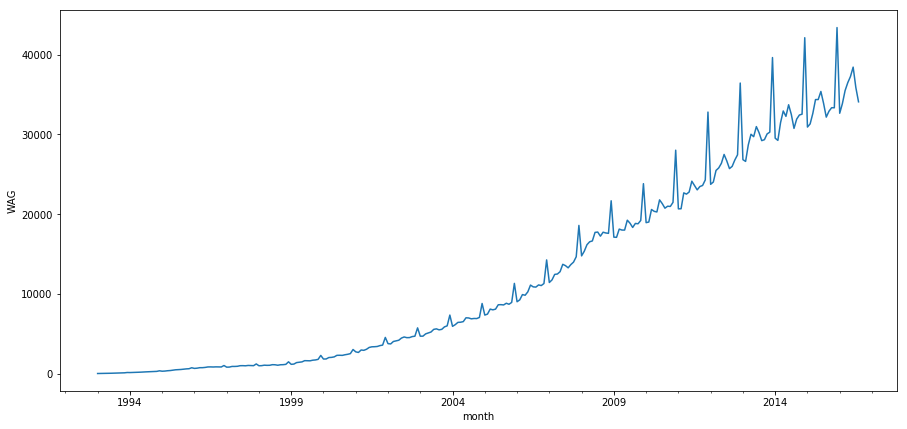

In [35]:
data = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel('WAG')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

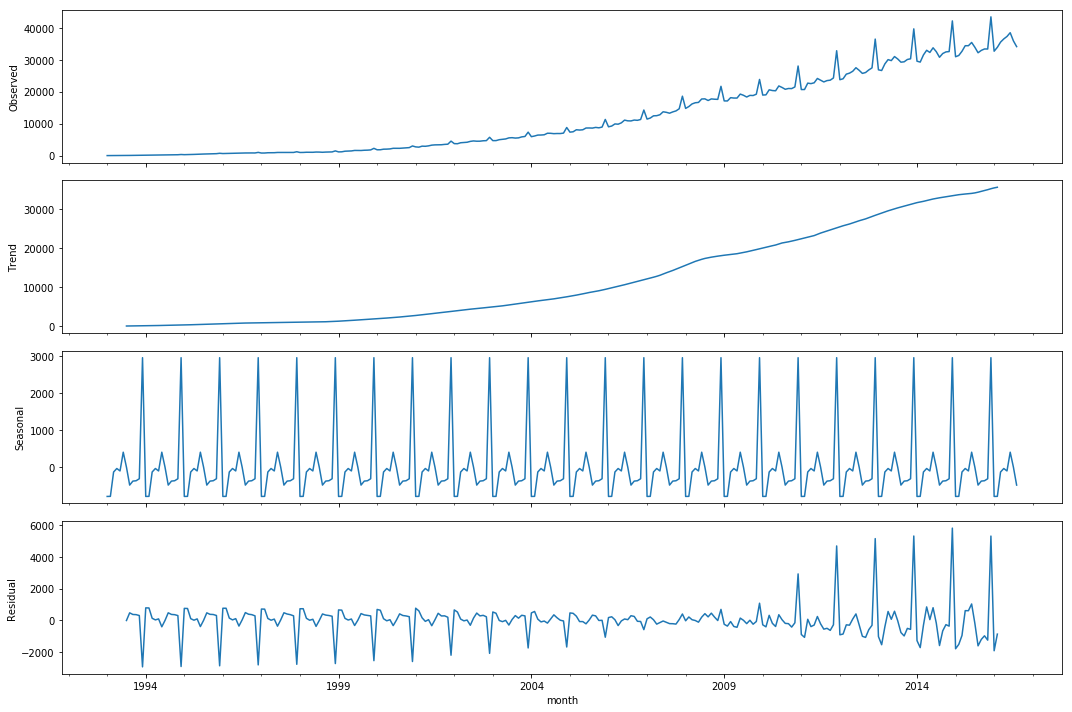

In [36]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

Присутствует явно выраженный тренд, который монотонно возрастает (что радует =) ), сезонность; ошибки мало похожи на белый шум.

## Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


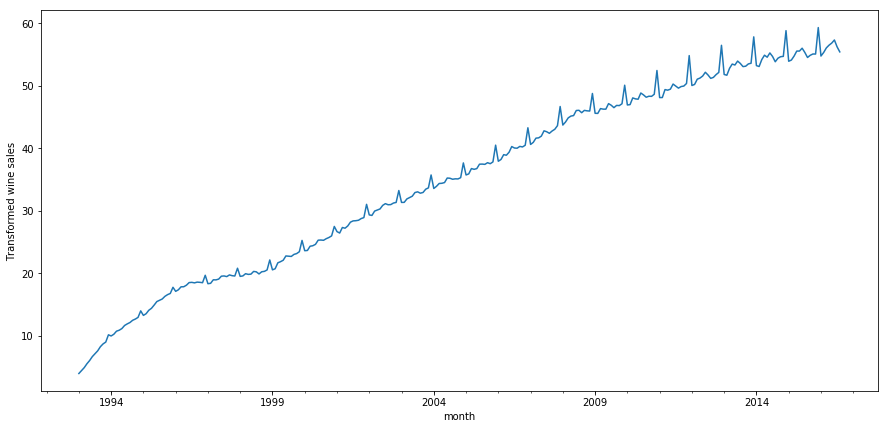

In [37]:
data['wag_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.wag_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_box)[1])

Гипотеза о нестационарности не отвергается.

## Стационарность

В данных по-прежнему присутствуют тренд и сезонность. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

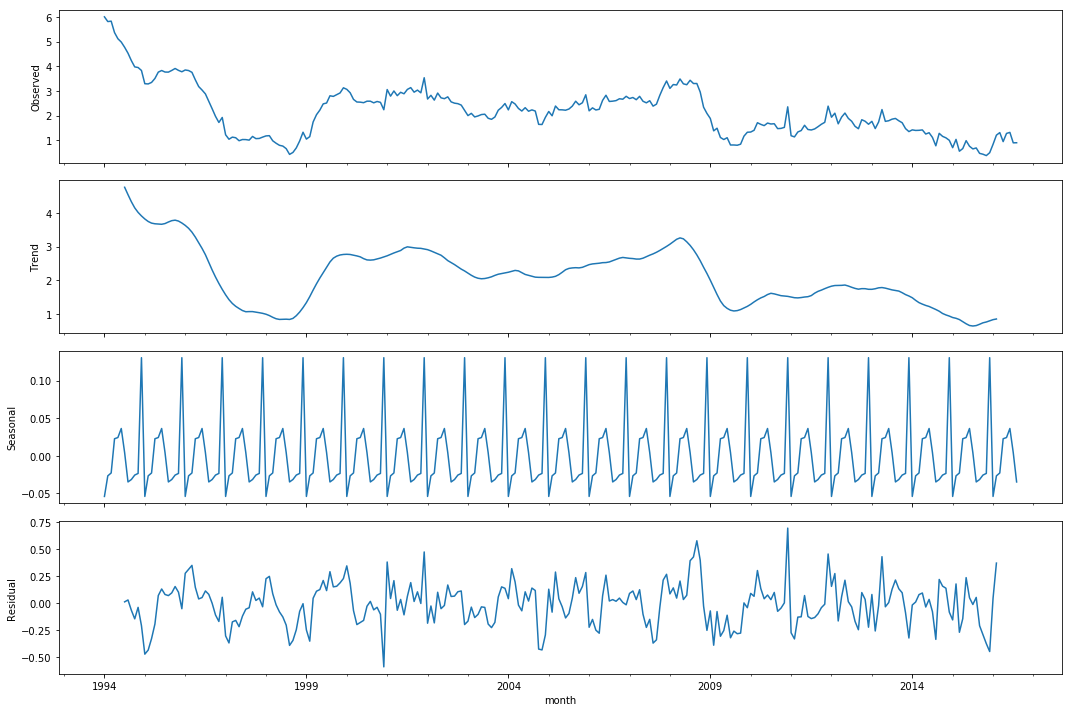

In [38]:
data['wag_box_diff'] = data.wag_box - data.wag_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wag_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_box_diff[12:])[1])

Гипотеза о нестационарности критерием Дики-Фуллера отвергается, но тренд похоже имеет сложную зависимость, в ошибки в среднем больше 0. Попробуем обычное дифференцирование.

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

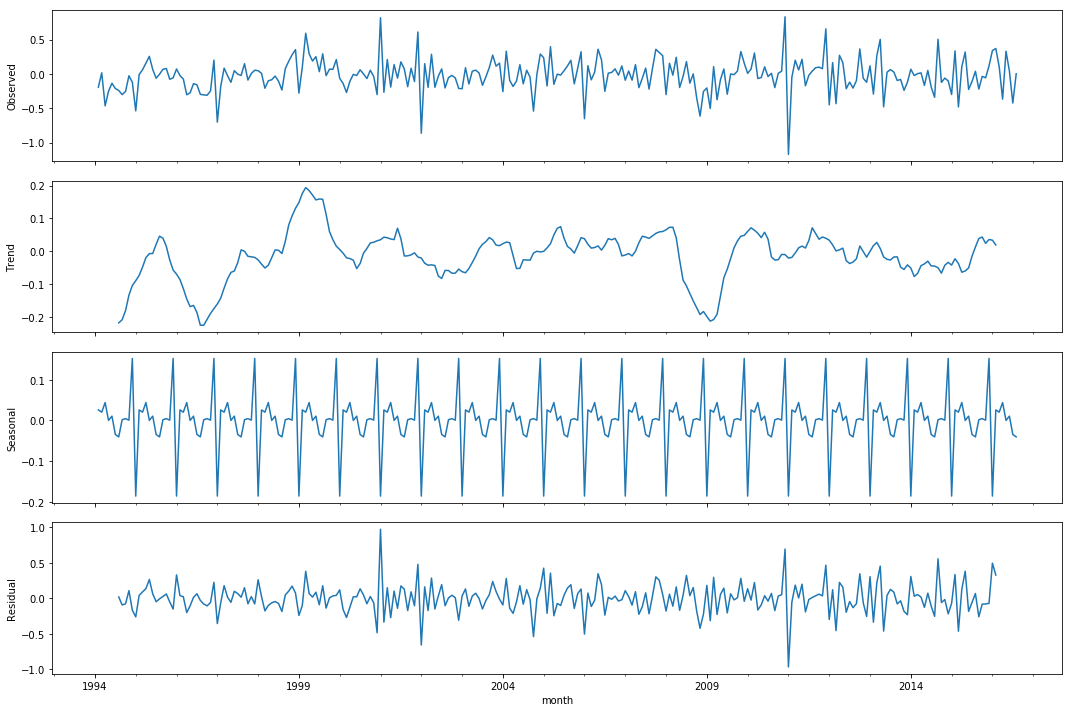

In [39]:
data['wag_box_diff2'] = data.wag_box_diff - data.wag_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wag_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_box_diff2[13:])[1])

Сейчас ошибки уже больше похожи на белый шум, а достигаемый уровень значимости в критерии Дики-Фуллера очень маленький. Также в тренде стала меньше проглядываться какая-либо зависимость. При выборе параметра дифференцирования больше 1 тренд лишь сглаживается.

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

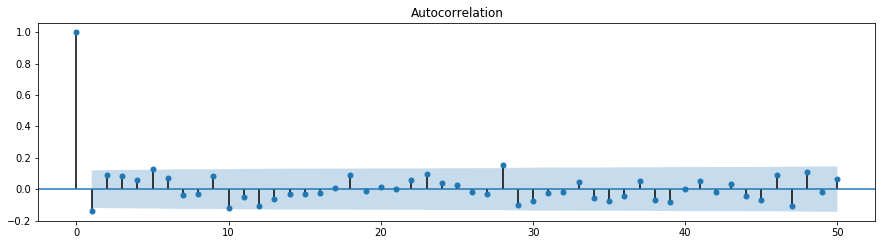

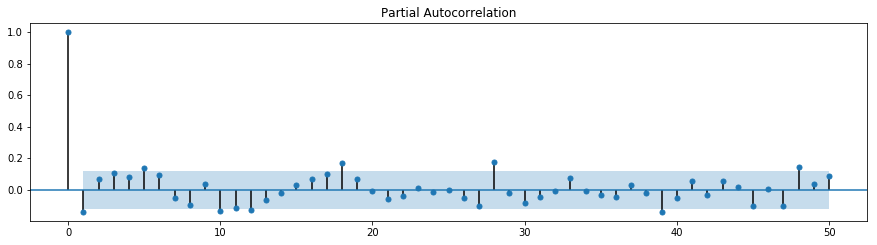

In [40]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wag_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wag_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=1, P=4, p=5.

In [57]:
ps = range(0, 6)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 2)

In [58]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

120

In [59]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.wag_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 2, 1))
('wrong parameters:', (2, 1, 3, 0))
('wrong parameters:', (2, 1, 3, 1))
('wrong parameters:', (2, 1, 4, 0))
('wrong parameters:', (2, 1, 4, 1))
Wall time: 25min 23s


In [60]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
99   (5, 0, 4, 1) -15.803094
109  (5, 1, 4, 1) -15.313534
69   (3, 1, 4, 1) -14.959361
89   (4, 1, 4, 1) -14.519874
79   (4, 0, 4, 1) -10.718875


Лучшая модель:

In [61]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            wag_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 0)x(4, 1, 1, 12)   Log Likelihood                  18.902
Date:                            Wed, 12 Sep 2018   AIC                            -15.803
Time:                                    23:10:53   BIC                             23.820
Sample:                                01-01-1993   HQIC                             0.106
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1452      0.049     -2.956      0.003      -0.241      -0.049
ar.L2          0.0174      0.071   

Её остатки:

Критерий Стьюдента: p=0.992492
Критерий Дики-Фуллера: p=0.000000


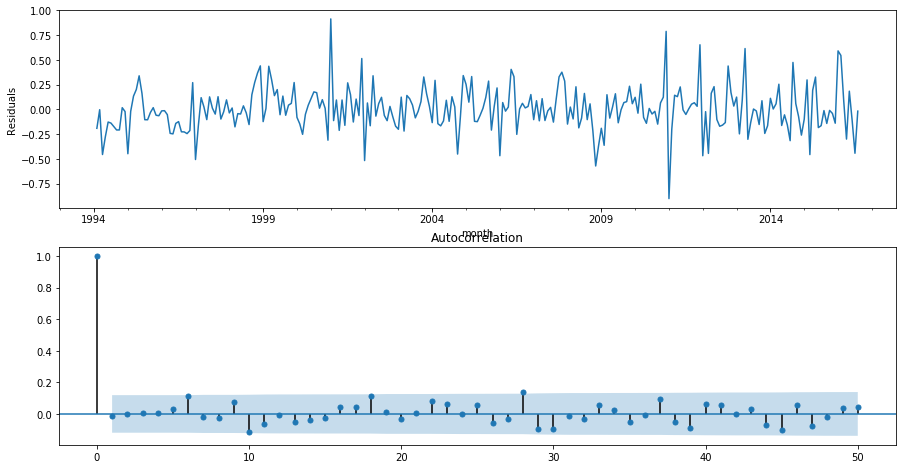

In [62]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=50, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

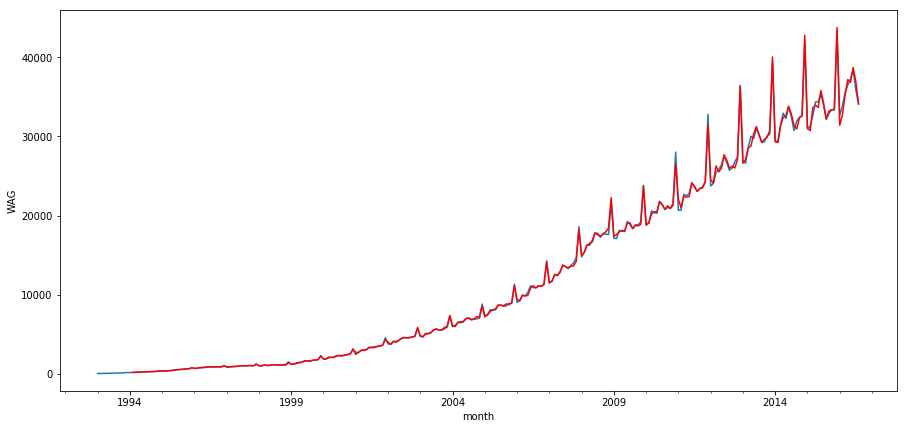

In [63]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('WAG')
pylab.show()

## Прогноз

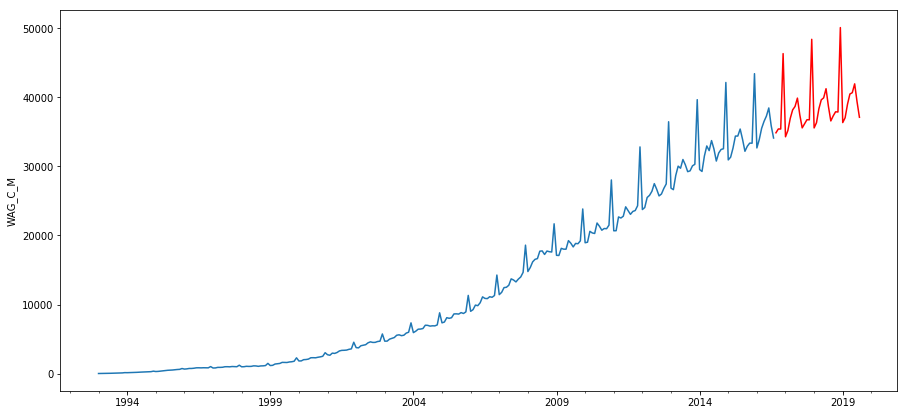

In [64]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=319), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()

Модель достаточно хорошо описывает исходную модель, а предсказания кажутся довольно убедительными и логичными.

In [65]:
real_values = pd.read_csv('WAG_C_M2.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)

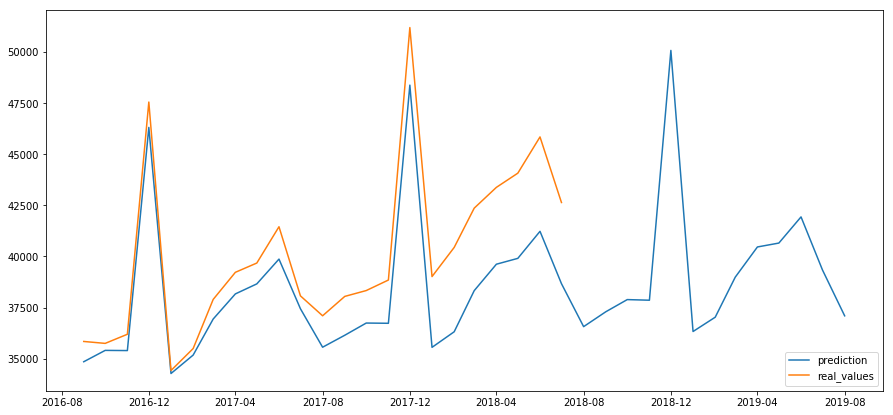

In [66]:
plt.plot(data2.forecast.index, data2.forecast, label='prediction')
plt.plot(real_values.index, real_values.WAG_C_M, label='real_values')
pylab.legend(loc = "lower right")